# Create XGBoost Model  

Given the tokenization encoding from **bge-m3** and some of the attributes from the post, predict whether the post is negative, positive, or neutral

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
%%time 

# ================================
# Load Dataset 
# ================================
import sys
sys.path.append("../scripts/")

from data_collection import authenticate_google_drive, grab_google_drive_folder_data

drive = authenticate_google_drive('0_data_collection/credentials/google_drive_client_secret.json')
# file_path_labelled = "labelled_consine_similarity.csv"
file_path = "data_encoded_BAAI/bge-m3"
data  = grab_google_drive_folder_data(drive=drive,credential_file="0_data_collection/credentials/google_drive_folder_id.json",filename=file_path)

file_path = "combined_output.csv"
labeled_data  = grab_google_drive_folder_data(drive=drive,credential_file="0_data_collection/credentials/google_drive_folder_id.json",filename=file_path)

# Merge in the label to the data  with the tokenizations
combined_df = pd.merge(labeled_data, data, on=['submission_id', 'subredit_topic', 'search_query'], how='left')
print(combined_df.shape)

Successfully loaded 'data_encoded_BAAI/bge-m3' into a DataFrame!
Successfully loaded 'combined_output.csv' into a DataFrame!
(45, 1039)
CPU times: user 2.45 s, sys: 708 ms, total: 3.15 s
Wall time: 13.9 s


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

In [5]:
# ================================
# Feature Prep & Split Data 
# ================================
label_mapping = {
    'Neutral': 0,
    'Negative': 1,
    'Positive': 2
}

combined_df['label_encode'] = combined_df['label'].map(label_mapping)

tokenization_columns_numerical = list(combined_df.columns)[15:]
categorical = ['subredit_topic', 'search_query']
target = 'label_encode'

X = combined_df[categorical + tokenization_columns_numerical]
y = combined_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=13)

In [6]:
# ================================
# Handle Class Imbalance & Create model pipeline
# ================================
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)  # One-hot encode categorical features
    ]
)

# Compute class weights to offset the class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print("Class Weights:", class_weights)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=[class_weight_dict[0], class_weight_dict[1], class_weight_dict[2]],
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)


Class Weights: [0.40909091 2.25       9.        ]


/Users/andreeaserban/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:37:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subredit_topic',
                                                   'search_query'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

Training Dataset:
 |    |   label_encode |
|---:|---------------:|
|  0 |             22 |
|  1 |              4 |
|  2 |              1 |
Testing Dataset:
 |    |   label_encode |
|---:|---------------:|
|  0 |             12 |
|  1 |              5 |
|  2 |              1 |


/Users/andreeaserban/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andreeaserban/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andreeaserban/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

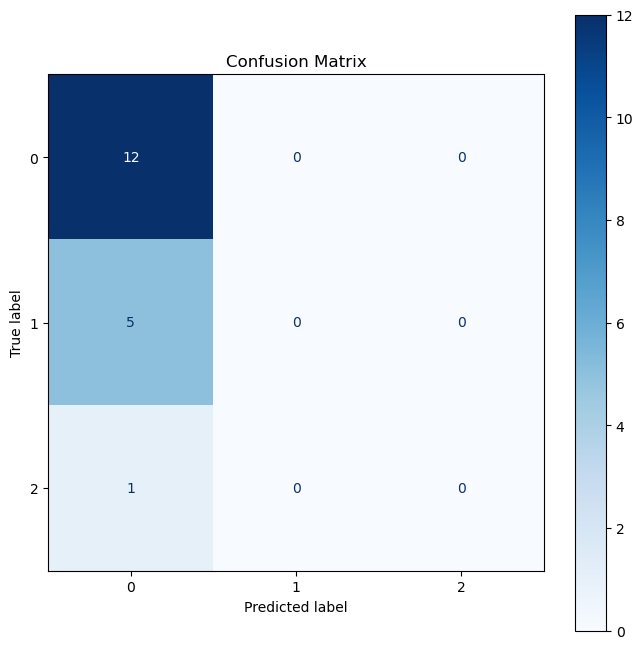

In [7]:
# ================================
# Evaluate the Model 
# ================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Training Dataset:\n", y_train.value_counts().to_markdown())
print("Testing Dataset:\n", y_test.value_counts().to_markdown())


y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [8]:
pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['subredit_topic', 'search_query'])]),
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, ...)}

,score
f6,0.088520
f3,0.064887
f1,0.021481
f10,0.014091
f13,0.012381
f11,0.011481


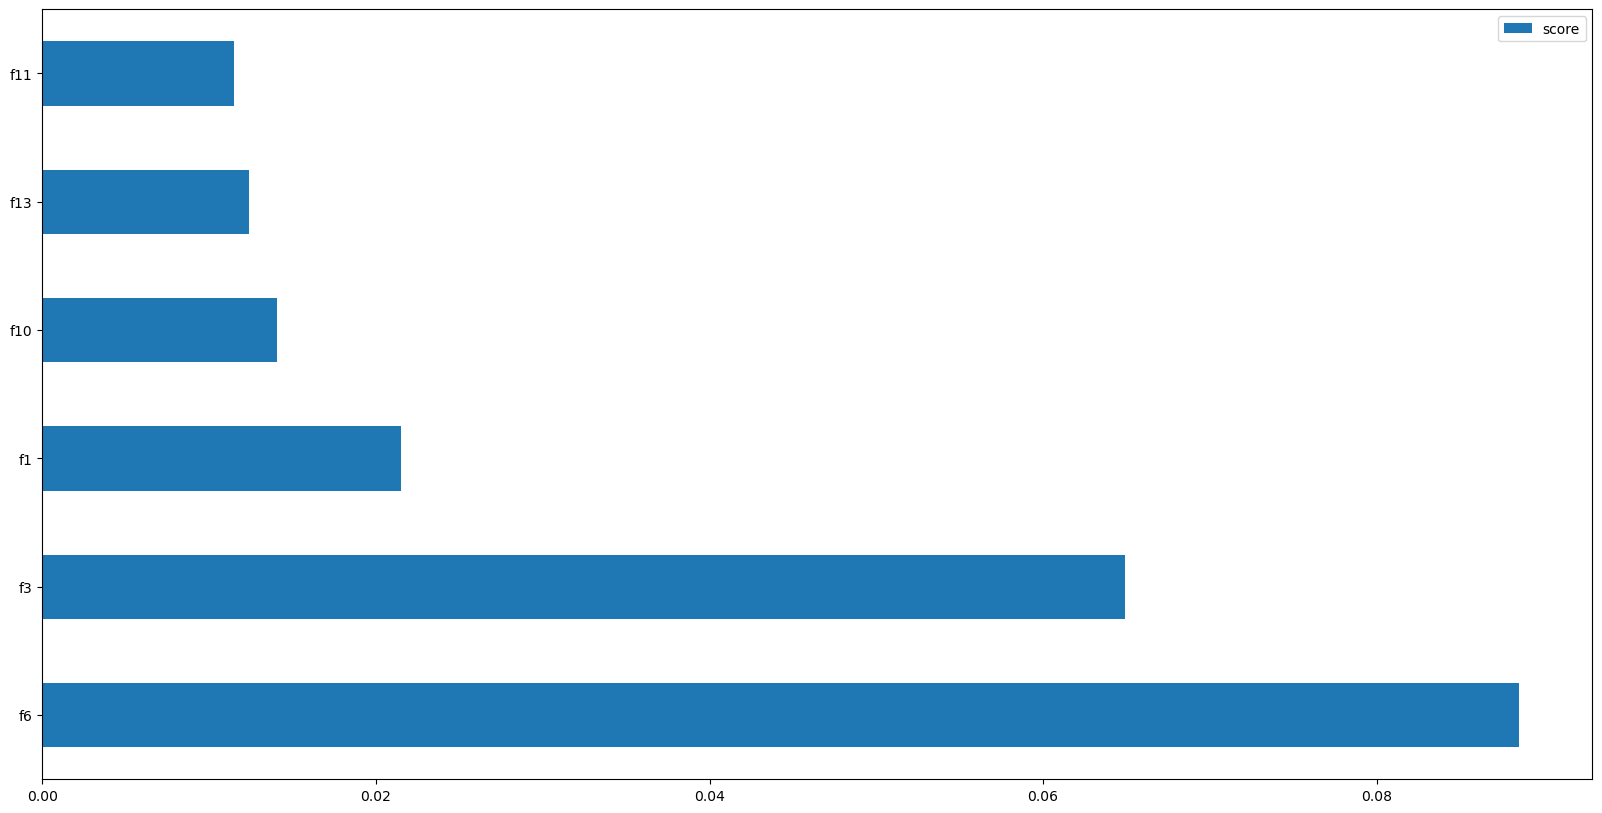

In [9]:
# ================================
# Feature Importance
# ================================

# --- 1. Extract raw feature importance ---
booster = pipeline.named_steps['model'].get_booster()
feature_important = booster.get_score(importance_type='gain')  # Options: 'weight', 'gain', 'cover'

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
data

<Axes: xlabel='label', ylabel='6'>

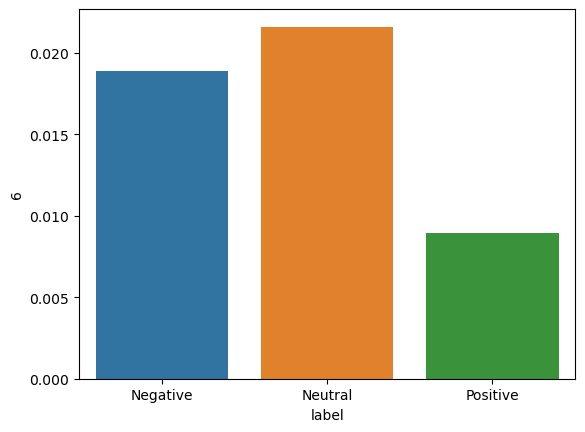

In [24]:
# combined_df.head() 
import seaborn as sns 

feature_analyze = combined_df.groupby('label').agg({'6': 'mean', '3': 'mean', '1':'mean'}).reset_index() 
sns.barplot(feature_analyze, x='label', y='6')


<Axes: xlabel='label', ylabel='3'>

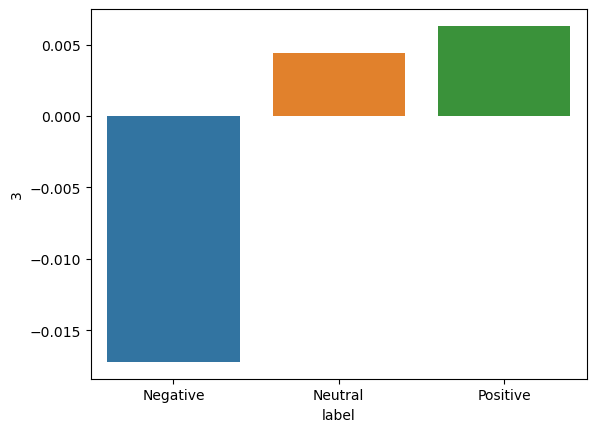

In [25]:
sns.barplot(feature_analyze, x='label', y='3')
